In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
from tqdm import tqdm
import sys

from astropy.coordinates import Distance
import bilby

# Add module
sys.path.append('../../modules')
from compute_omega import sample_dict_compute_injected_omega
from gwBackground_module import *
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator

from constants import *
import equations
import redshiftPrior

In [2]:
# Plot formatting
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]  

In [3]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Frequency Parameters
fmax = 3000
fref = 25

# Data Simulation Parameters
T_obs = (7/365.25) # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
N_segs = 1 # number of data segments to generate
fs = 4096 # sampling rate (in Hz)
num_iterations = 12 # number of iterations to average Omega(f) over

In [4]:
# Standard Prior Dictionary
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors['luminosity_distance']
del priors['chirp_mass']

15:55 bilby INFO    : Using aligned spin prior
15:55 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [5]:
# Calculate number of injections
def calculate_num_injections(T_obs, priors):
    zs, p_dz = priors['redshift']._get_redshift_arrays()
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    N = T_obs * total_sum
    print(p_dz)
    return N

zs, p_dz = priors['redshift']._get_redshift_arrays()
N = calculate_num_injections(T_obs, priors)
print(N)

[  0.           3.18473004  12.8720701  ... 457.38880608
 455.14080154 452.90572928] 1 / yr
4608.473779178938 1 / yr


In [ ]:
# Regimbau Method
# Create injections
N_inj = np.random.poisson(N.value)
injections = priors.sample(N_inj)
injections["signal_type"] = 'CBC'
print('Total number of injections: ' + str(N_inj))

import json
with open("test_CBC_injection_dict.json", "w") as outfile:
    json.dump(injections, outfile, indent=2, cls=bilby.core.result.BilbyJsonEncoder
)

freqs_d, omega_gw_d = compute_injected_omega(injections, T_obs,
                                        return_spectrum=True,
                                        sampling_frequency=4096,
                                        duration=2)

freqs_pv2, omega_gw_pv2 = compute_injected_omega(injections, T_obs,
                                        return_spectrum=True,
                                        sampling_frequency=4096,
                                        duration=2,
                                        approximant='IMRPhenomPv2')

freqs_tf2, omega_gw_tf2 = compute_injected_omega(injections, T_obs,
                                        return_spectrum=True,
                                        sampling_frequency=4096,
                                        duration=2,
                                        approximant='TaylorF2')

# Plot spectrum
plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.loglog(freqs_d, omega_gw_d, color='#d61c1c')
ax.loglog(freqs_pv2, omega_gw_pv2, color='#000000')
ax.loglog(freqs_tf2, omega_gw_tf2, color='#000000')

ax.set_xlim(10, 1000)
ax.set_title(r'GW Energy Density Spectrum (Regimbau Method)')
ax.set_xlabel(r'Frequency (Hz)', fontsize=16)
ax.set_ylabel(r'$\Omega_{GW}(f)$', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend()

# print('Omega_ref at 25 Hz: ' + format(Omega_ref_AR, '.2e'))

In [ ]:
# Regimbau Method
# Plot spectrum
plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.set_xlim(10, 1000)
ax.set_title(r'GW Energy Density Spectrum (Regimbau Method)')
ax.set_xlabel(r'Frequency (Hz)', fontsize=16)
ax.set_ylabel(r'$\Omega_{GW}(f)$', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend()

for iteration in range(num_iterations):
    # Create injections
    N_inj = np.random.poisson(N.value)
    injections = priors.sample(N_inj)
    injections["signal_type"] = 'CBC'
    print('Total number of injections: ' + str(N_inj))
    
    import json
    with open("test_CBC_injection_dict.json", "w") as outfile:
        json.dump(injections, outfile, indent=2, cls=bilby.core.result.BilbyJsonEncoder
    )
    
    freqs_d, omega_gw_d = compute_injected_omega(injections, T_obs,
                                        return_spectrum=True,
                                        sampling_frequency=4096,
                                        duration=2)

    freqs_pv2, omega_gw_pv2 = compute_injected_omega(injections, T_obs,
                                            return_spectrum=True,
                                            sampling_frequency=4096,
                                            duration=2,
                                            approximant='IMRPhenomPv2')

    freqs_tf2, omega_gw_tf2 = compute_injected_omega(injections, T_obs,
                                            return_spectrum=True,
                                            sampling_frequency=4096,
                                            duration=2,
                                            approximant='TaylorF2')
    
    ax.loglog(freqs_d, omega_gw_d, color='#d61c1c')
    # ax.loglog(freqs_pv2, omega_gw_pv2, color='#000000')
    # ax.loglog(freqs_tf2, omega_gw_tf2, color='#000000')

In [ ]:
# Callister Method
# Set up OmegaGW object
inspiralOnly = False
m1_min = BBH_min
m1_max = BBH_max
m2_min = BBH_min
m2_max = BBH_max
minimum_component_mass = BBH_min
maximum_component_mass = BBH_max
omg = OmegaGW_BBH(minimum_component_mass, maximum_component_mass, zs)

# Calculate merger rate
mergerRate = equations.get_R_array(zs, alpha, beta, zp, R0)

# Calculate probability grid
# Priors defined in (m1, q) space
probs = np.empty((omg.m1s_2d.shape[0], omg.qs_2d.shape[1])) # initialize array
for i in range(omg.m1s_2d.shape[0]): # for each m1
    for j in range(omg.qs_2d.shape[1]): # for each q
        prob = priors.prob({'mass_1':omg.m1s_2d[i][j], 'mass_ratio':omg.qs_2d[i][j]}) # calculate probability
        probs[i][j] = prob # insert probability into probability array
probs = probs*(omg.Mtots_2d/(1. + omg.qs_2d)) # multiply by the Jacobian

# Limit probabilities to physical masses
probs[omg.m1s_2d < m1_min] = 0
probs[omg.m1s_2d > m1_max] = 0
probs[omg.m2s_2d < m2_min] = 0
probs[omg.m2s_2d > m2_max] = 0

# Normalize probabilities
probs /= np.sum(probs)
omg.probs = probs

# Calculate Omega(f)
freqs_TC = np.logspace(0, np.log10(fmax), 200)
OmegaGW_TC = omg.eval(R0, mergerRate, freqs_TC)

# Find OmegaGW(fref)
fref_approx_TC = 100
fref_approx_index_TC = 0
for i in range(len(freqs_TC)):
    if(np.absolute(freqs_TC[i] - fref) < fref_approx_TC):
        fref_approx_TC = np.absolute(freqs_TC[i] - fref)
        fref_approx_index_TC = i
Omega_ref_TC = OmegaGW_TC[fref_approx_index_TC]

# Plot
fig, ax = plt.subplots()
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa')
ax.loglog(freqs_TC, Omega_ref_TC*(freqs_TC/fref)**(2/3), label='2/3 Power Law', color='#000000')
ax.set_title(r'GW Energy Density Spectrum (Callister Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()

In [ ]:
# Combined Method
total_freqs_CB = []
total_OmegaGW_CB = []
# total_Omega_ref_CB = 0
for iteration in range(num_iterations):
    # Determine number of injections
    N_inj = np.random.poisson(N.value)
    injections = priors.sample(N_inj)
    m1s = injections['mass_1']
    qs = injections['mass_ratio']
    m2s = []
    Mtots = [] # m1 + m2
    events = [] # array of chirp masses
    for i in range(len(injections['mass_1'])):
        m2s.append(equations.calculate_m2(m1s[i], qs[i]))
        Mtots.append(equations.calculate_Mtot(m1s[i], m2s[i]))
        events.append(equations.calculate_M(m1s[i], m2s[i]))

    # Calculate Omega(f)
    freqs_CB = []
    OmegaGW_values_CB = []

    for i in range(1, fmax):
        f = i # frequency (in Hz)

        # Equation from Renzini et al. 2022.
        # Calculate the GW energy density by summing the spectral energy density from individual BBH events across redshift space.
        def integrand(z):
            f_ref = f*(1 + z)
            r = equations.R_SI(alpha, beta, z, zp, R0)
            ave_dedf = equations.ave_dEdf_SI(f_ref, Mtots, events)
            h = equations.Hubble_rate_SI(z, H0, omegaR, omegaM, omegak, omegaL)
            return r*ave_dedf/((1 + z)*h)

        integral = scipy.integrate.quad(integrand, 0, z_max)
        OmegaGW = f/equations.pc_SI(H0)*integral[0]
        freqs_CB.append(f)
        OmegaGW_values_CB.append(OmegaGW)
    
    if iteration == 0:
        total_freqs_CB = freqs_CB
        total_OmegaGW_CB = OmegaGW_values_CB
    else:
        for freq in range(len(freqs_CB)):
            total_freqs_CB[freq] += freqs_CB[freq]
            total_OmegaGW_CB[freq] += OmegaGW_values_CB[freq]
    
for i in range(len(total_freqs_CB)):
    total_freqs_CB[i] /= num_iterations
    total_OmegaGW_CB[i] /= num_iterations

# Find OmegaGW(fref)
fref_approx_CB = 100
fref_approx_index_CB = 0
for i in range(len(freqs_CB)):
    if(np.absolute(freqs_CB[i] - fref) < fref_approx_CB):
        fref_approx_CB = np.absolute(freqs_CB[i] - fref)
        fref_approx_index_CB = i
Omega_ref_CB = total_OmegaGW_CB[fref_approx_index_CB]

# Plot
fig, ax = plt.subplots()
ax.loglog(total_freqs_CB, total_OmegaGW_CB, color='#25cc33')
ax.loglog(total_freqs_CB, Omega_ref_CB*(np.array(total_freqs_CB)/fref)**(2/3), label='2/3 Power Law', color='#000000')
ax.set_title(r'GW Energy Density Spectrum (Combined Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()

In [14]:
# Weighted Method (Waveform Generator)
# Uniform Prior Dictionary
uniform_priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
uniform_priors['mass_1'] = bilby.core.prior.Uniform(minimum=BBH_min, maximum=BBH_max, name='mass_1_uniform')
uniform_priors['mass_ratio'] = bilby.core.prior.Uniform(minimum=0, maximum=1, name='mass_ratio_uniform')
uniform_priors['redshift'] = bilby.core.prior.Uniform(minimum=0, maximum=z_max, name='redshift_uniform')

# Draw samples
N_inj = np.random.poisson(N.value)
injections = priors.sample(N_inj)

m1s = injections['mass_1']
qs = injections['mass_ratio']
zs = injections['redshift']
m2s = []
Mtots = [] # m1 + m2
Ms = [] # chirp masses
for i in range(len(injections['mass_1'])):
    m2s.append(equations.calculate_m2(m1s[i], qs[i]))
    Mtots.append(equations.calculate_Mtot(m1s[i], m2s[i]))
    Ms.append(equations.calculate_M(m1s[i], m2s[i]))

# Set up waveform generator
# Waveform generator parameters
sampling_frequency=4096
approximant='IMRPhenomD'

# Initialize waveform generator
waveform_generator = bilby.gw.WaveformGenerator(
    duration=2,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments={
        "waveform_approximant": approximant,
        "reference_frequency": 50,
        "minimum_frequency": 1
    }
)

# Calculate non-weighted dEdf from uniform distributions
freqs_W = waveform_generator.frequency_array
OmegaGW_W = np.zeros(len(freqs_W))

dEdfs = []
for i in range(N_inj):
    inj_params = {}
    # Generate the individual parameters dictionary for each injection
    for k in injections.keys():
        if k == 'signal_type':
            continue
        try:
            inj_params[k] = injections[k]['content'][i]
        except:
            inj_params[k] = injections[k][i]

    # Get frequency domain waveform
    polarizations = waveform_generator.frequency_domain_strain(inj_params)

    # Final PSD of the injection
    dEdf = np.abs(polarizations['plus']) ** 2 + np.abs(polarizations['cross']) ** 2
    dEdfs.append(dEdf)
    
# Calculate Omega(f)
dEdf_sum = 0
for i in range(N_inj):
    z = zs[i]
    m1 = m1s[i]
    m2 = m2s[i]
    q = qs[i]
    Mtot = Mtots[i]
    M = Ms[i]

    # Probability of drawing {z, m1, m2}
    p_z = priors['redshift'].prob(z)
    p_m1 = priors['mass_1'].prob(m1)
    p_q = priors['mass_ratio'].prob(q)

    pdraw_z = uniform_priors['redshift'].prob(z)
    pdraw_m1 = uniform_priors['mass_1'].prob(m1)
    pdraw_q = uniform_priors['mass_ratio'].prob(q)

    # Weight calculation
    r = equations.R_SI(alpha, beta, z, zp, R0)
    h = equations.Hubble_rate_SI(z, H0, omegaR, omegaM, omegak, omegaL)
    h0 = equations.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)

    wi = (p_z/pdraw_z) * (p_m1/pdraw_m1) * (p_q/pdraw_q)
    dEdf = wi*dEdfs[i]

    dEdf_sum += dEdf
    
    # Add to Omega_spectrum
    # OmegaGW_W += 2 * np.pi**2 * freqs_W**3 * dEdf / (3 * h0**2)
OmegaGW_W = 2 * np.pi**2 * freqs_W**3 * dEdf_sum / (3 * h0**2)
Tobs_seconds = T_obs * 86400 * 365.25  # years to seconds
OmegaGW_W *= 2 / Tobs_seconds

01:45 bilby INFO    : Using aligned spin prior
01:45 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.
01:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [15]:
freqs_psd, omega_gw_freq, injections = sample_dict_compute_injected_omega(priors, Tobs=(7/365.25), duration=2, f_ref=25, sampling_frequency=4096,
                                       approximant='IMRPhenomD')

2023-12-07 01:47:01.408 | INFO     | compute_omega:draw_injections:60 - We are averaging over 4608.473779178938 1 / yr waveforms for 0.019 years
01:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2023-12-07 01:47:01.531 | INFO     | compute_omega:sample_dict_compute_injected_omega:95 - Compute the total injected Omega for 4537 injections
100%|██████████| 4537/4537 [00:17<00:00, 266.54it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


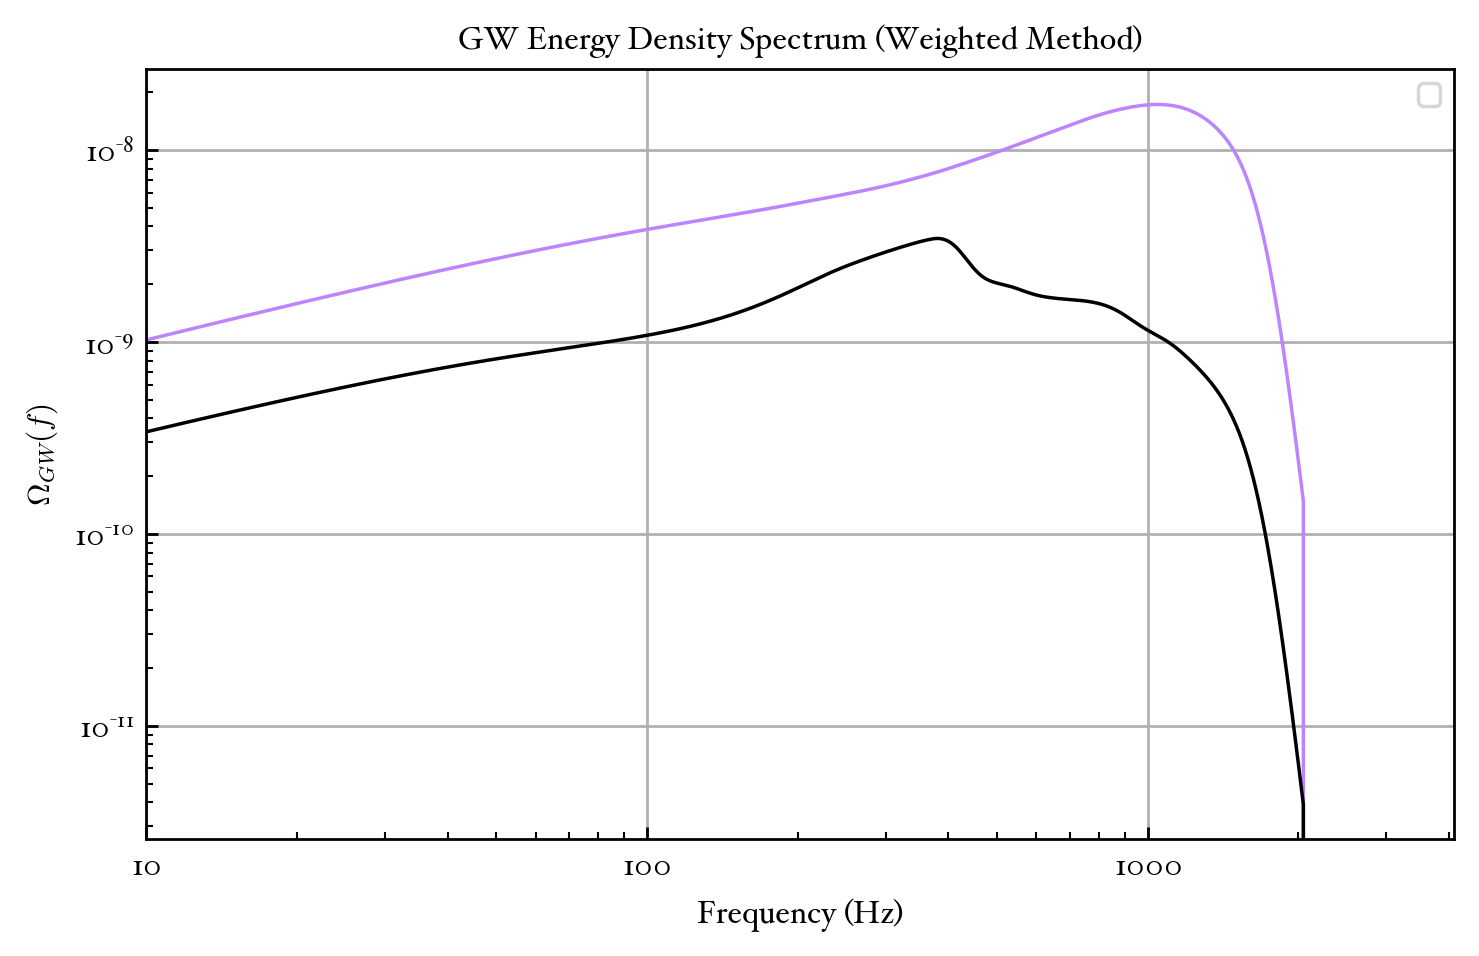

In [16]:
%matplotlib inline
fig, ax = plt.subplots()
ax.loglog(freqs_W, OmegaGW_W, color='#bc85ff')
ax.loglog(freqs_psd, omega_gw_freq, color='#000000')
ax.set_title(r'GW Energy Density Spectrum (Weighted Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 4096)
ax.legend()

In [ ]:
fig, ax = plt.subplots()
ax.loglog(freqs_d, omega_gw_d, color='#d61c1c', label='Regimbau Method')
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa', label='Callister Method')
ax.loglog(total_freqs_CB, total_OmegaGW_CB, color='#25cc33', label='Combined Method')
ax.loglog(freqs_tf2, omega_gw_tf2, label='2/3 Power Law (Regimbau)', color='#991414')
ax.loglog(freqs_TC, Omega_ref_TC*(freqs_TC/fref)**(2/3), label='2/3 Power Law (Callister)', color='#1f769c')
ax.loglog(freqs_CB, Omega_ref_CB*(np.array(freqs_CB)/fref)**(2/3), label='2/3 Power Law (Combined)', color='#14751c')
ax.set_title(r'GW Energy Density Spectrum')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
ax.legend()
fig.show()